In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import tensorflow as tf
from scipy import stats
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2

from tqdm import tqdm
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib import cm

# Data
from seird.model import data_generator

# Model
from bayesflow.networks import SequenceNet, HeteroskedasticModel
from bayesflow.bayesflow_model import BayesFlow
from bayesflow.trainer import train_step
from bayesflow.losses import heteroskedastic_loss, maximum_likelihood_loss

# Misc
from utils.misc import true_vs_estimated


%load_ext autoreload
%autoreload 2

In [3]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'lstm_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


# Forward model hyperparameters
parameter_names = [r'$\beta$', r'$\sigma$', r'$\gamma$', r'$\delta$', r'$\eta$']
theta_dim = len(parameter_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = 'bayesflow_parameter_estimation_v2'
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [4]:
%%time
data_test = data_generator(n_test, version='v2')

# Preprocessing untrained data
X_test = np.array(data_test['X'])
params_test = np.array(data_test['params'])

CPU times: user 164 ms, sys: 4.68 ms, total: 169 ms
Wall time: 173 ms


In [5]:
print(type(X_test))
print(X_test.shape)
print(type(params_test))
print(params_test.shape)

<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 5)


In [6]:
# Sanity checks for numerical stability
assert(np.sum(X_test == np.inf) == 0)
assert(np.sum(X_test == -np.inf) == 0)
assert(np.sum(X_test == np.nan) == 0)

In [7]:
print(X_test.shape)
print(params_test.shape)

(500, 100, 5)
(500, 5)


In [8]:
# Instantiate model
summary_net = SequenceNet()
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

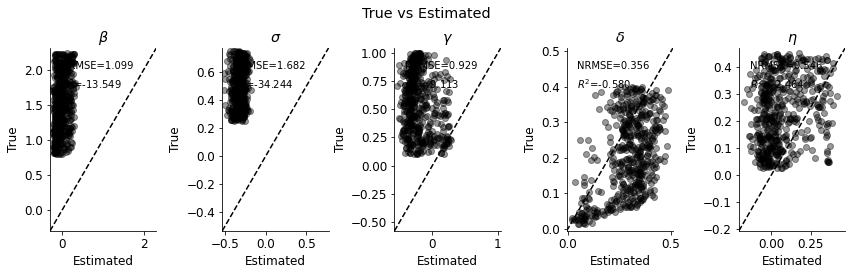

In [9]:
true_vs_estimated(model, X_test, params_test, n_samples_posterior, parameter_names, figsize=(12, 4))

In [10]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [11]:
# %%time
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_step(
            model=model, 
            optimizer=optimizer,
            loss_fn=maximum_likelihood_loss, 
            iterations=iterations_per_epoch,
            batch_size=batch_size,
            p_bar=p_bar,
            global_step=global_step,
            version='v2'
        ) 

        # Manage checkpoint
        manager.save()

Training epoch 71: 100%|██████████| 1000/1000 [05:43<00:00,  2.91it/s, Iteration: 1000, Loss: -30.912199020385742]


Training epoch 100: 100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s, Iteration: 1000, Loss: -31.8121337890625]
